Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score
import tensorflow as tf
import imageio
import pylab

In [2]:
rng = np.random.RandomState(128)

Setting directories

In [3]:
root_dir = os.path.abspath('C:/Users/Anagha Rumade/Documents/Python Scripts/TensorFlow')
Images_dir = os.path.join(root_dir, 'Images')

print(os.path.exists(root_dir))
print(os.path.exists(Images_dir))

True
True


Reading the training file

In [4]:
train_data_labels = pd.read_csv(root_dir + '/train.csv') 

In [5]:
train_data_labels.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


Taking a look at one of the input images

In [6]:
img = rng.choice(train_data_labels.filename)

In [7]:
filepath = os.path.join(Images_dir, 'train', img)

In [8]:
image = imageio.imread(filepath)

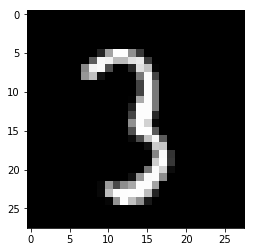

In [9]:
pylab.imshow(image)
pylab.show()

Stacking all the Input Images in a numpy array

In [10]:
%%time
all_images = []
for img_name in train_data_labels.filename:
    filepath = os.path.join(Images_dir, 'train', img_name)
    image = imageio.imread(filepath)
    image = image.astype('float32')
    all_images.append(image)

Wall time: 38.2 s


In [11]:
all_images[0]

Array([[[  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.],
        ...,
        [  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.]],

       [[  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.],
        ...,
        [  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.]],

       [[  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.],
        ...,
        [  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.]],

       ...,

       [[  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.],
        ...,
        [  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.]],

       [[  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.],
        [  0.,   0.,   0., 255.],
        .

In [12]:
%%time
train_x = np.stack(all_images)

Wall time: 901 ms


In [13]:
train_x.shape

(49000, 28, 28, 4)

Here, we see that the data shape is something as follows:
<br>34300 Rows
<br>28 columns
<br>28 height dimension columns
<br>and 4 elements in each of these

Something like a cube structure but more rectangular with each little cube in the structure holding 4 elements

Splitting the data into training and validation sets

In [14]:
split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train_data_labels[:split_size], train_data_labels[split_size:]

Setting all Variables

In [15]:
#Number of Neurons in every layer
num_neurons_input = 28*28
num_neurons_output = 10
num_neurons_hidden = 500

In [16]:
#Placeholders
x = tf.placeholder(tf.float32, [None, num_neurons_input])
y = tf.placeholder(tf.float32, [None, num_neurons_output])

In [17]:
#Setting variables
epoch = 5
batch_size = 128
learning_rate = 0.01

In [18]:
weights = {
    'hidden': tf.Variable(tf.random_normal([num_neurons_input, num_neurons_hidden])),
    'output': tf.Variable(tf.random_normal([num_neurons_hidden, num_neurons_output]))
}

biases = {
    'hidden': tf.Variable(tf.random_normal([num_neurons_hidden])),
    'output': tf.Variable(tf.random_normal([num_neurons_output]))
}

Building Neural Networks Computational Graph

In [19]:
hidden_layer = tf.add(tf.matmul(x, weights['hidden']), biases['hidden'])
hidden_layer = tf.nn.relu(hidden_layer)

In [20]:
output_layer = tf.matmul(hidden_layer, weights['output']) + biases['output']

In [21]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output_layer, labels=y))

In [22]:
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

Useful functions

In [23]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors"""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot

In [24]:
#train_x/train_x.max()

In [25]:
def preproc(batch_normalize):
    batch_temp = batch_normalize/batch_normalize.max()
    return batch_temp

What does .reshape(-1, (28*28)) do?<br>
It creates an array compatible with the previous shape. -1 gives python the liberty to create its own number of rows

In [26]:
#train_x[[rng.choice(train_x.shape[0],5)]].reshape(-1, (28*28))

In [27]:
def batch_creator(batch_size, dataset_length, dataset_name):
    """Create batch with random samples and return appropriate format"""
    batch_mask = rng.choice(dataset_length, batch_size)
    
    batch_x = eval(dataset_name + '_x')[[batch_mask]].reshape(-1, num_neurons_input)
    batch_x = preproc(batch_x)
    
    batch_y = eval(dataset_name + '_y').loc[batch_mask, 'label'].values
    batch_y = dense_to_one_hot(batch_y)
        
    return batch_x, batch_y

In [28]:
init = tf.global_variables_initializer()

Creating a session and running it

In [29]:
#Initializing the session
with tf.Session() as sess:
    sess.run(init)
    
    for epoc in range(epoch):
        avg_cost = 0
        all_batches = int(train_x.shape[0]/batch_size)
        for batch in range(all_batches):
            batch_x, batch_y = batch_creator(batch_size, train_x.shape[0], 'train')
            _, c = sess.run([optimizer, cost], feed_dict={x:batch_x, y:batch_y})
            avg_cost += c/all_batches

        print('Epoch:' + (epoch+1) + ' cost: ' + avg_cost)

    print('Training Complete')

C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


InvalidArgumentError: logits and labels must be broadcastable: logits_size=[512,10] labels_size=[128,10]
	 [[{{node softmax_cross_entropy_with_logits}} = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](add_1, softmax_cross_entropy_with_logits/Reshape_1)]]

Caused by op 'softmax_cross_entropy_with_logits', defined at:
  File "C:\Users\Anagha Rumade\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 499, in start
    self.io_loop.start()
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Anagha Rumade\Anaconda3\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\Anagha Rumade\Anaconda3\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "C:\Users\Anagha Rumade\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-8223c7662f12>", line 1, in <module>
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output_layer, labels=y))
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1888, in softmax_cross_entropy_with_logits_v2
    precise_logits, labels, name=name)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 7747, in softmax_cross_entropy_with_logits
    name=name)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3272, in create_op
    op_def=op_def)
  File "C:\Users\Anagha Rumade\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): logits and labels must be broadcastable: logits_size=[512,10] labels_size=[128,10]
	 [[{{node softmax_cross_entropy_with_logits}} = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](add_1, softmax_cross_entropy_with_logits/Reshape_1)]]


In [30]:
_

(49000, 28, 28, 4)

In [31]:
cost

<tf.Tensor 'Mean:0' shape=() dtype=float32>